In [1]:
#import SQL library
import pyodbc
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import matplotlib.ticker as ticker
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 26

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [2]:
#establishes an open connection to SQL
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=LENOVO-PC\SQLEXPRESS;'
                      'Database=AdventureWorks2012;'
                      'Trusted_Connection=yes;')

In [3]:
#pull RESELLER data from SQL including Territory and Revenue 

pythonSQLobject=pd.read_sql_query("""
SELECT * FROM [dbo].[ONLINE_SELLER_FORECAST]""", conn)

conn.close() # please close it after !


In [4]:
dataset = pythonSQLobject

In [5]:
dataset.head()

,OrderDate,Revenue,Territory_Name
0,2011-05-31,3578.2700,Canada
1,2011-05-31,3399.9900,France
2,2011-05-31,3399.9900,Northwest
3,2011-05-31,699.0982,Southwest
4,2011-05-31,3399.9900,Australia


In [6]:
dataset.shape

(60398, 3)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 3 columns):
OrderDate         60398 non-null datetime64[ns]
Revenue           60398 non-null float64
Territory_Name    60398 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.4+ MB


# Time Series Modeling with Prophet
## Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running

In [64]:
AU = dataset1.loc[dataset1['Territory_Name'] == 'Australia']
#dfa= dataset.loc[dataset['Territory_Name'] == 'Australia']
AU.shape

(13345, 3)

In [65]:
AU['OrderDate'] =  pd.to_datetime(AU['OrderDate'], format='%Y/%m')
AU = AU.sort_values(by=['OrderDate'], ascending=[True])
AU.set_index('OrderDate', inplace=True) # Indexing with Time Series Data

AU.drop(["Territory_Name"],axis=1, inplace=True)

In [66]:
#y = df.resample('MS').mean()
y_AU = AU.resample('MS').sum()


In [67]:
# filling up by mean value
y_AU = y_AU['Revenue'].replace(0.000000, y_AU['Revenue'].mean())

In [68]:
AU = pd.DataFrame({'OrderDate': y_AU.index, 'Revenue': y_AU.values})

### As we can see, this data was extracted begaining of June 2014 therefore need to exclude from dataset.

In [69]:
# drop June 2014
AU = AU.drop(AU.index[len(AU)-1])
AU.tail()

,OrderDate,Revenue
32,2014-01-01,435025.32
33,2014-02-01,355170.42
34,2014-03-01,468617.58
35,2014-04-01,413116.58
36,2014-05-01,479766.61


In [70]:
#store = AU.merge(SW,how='inner', on='OrderDate')
store = AU
store.rename(columns={'Revenue_x': 'SE_revenue'}, inplace=True)
store.head()

,OrderDate,Revenue
0,2011-05-01,3399.9900
1,2011-06-01,206252.9146
2,2011-07-01,222538.2892
3,2011-08-01,177393.5028
4,2011-09-01,214593.3928


# Fitt Model with Prophet

In [72]:
from fbprophet import Prophet
AU = AU.rename(columns={'OrderDate': 'ds', 'Revenue': 'y'})
AU_model = Prophet(interval_width=0.95)
AU_model.fit(AU)
AU_forecast = AU_model.make_future_dataframe(periods=60, freq='MS')
AU_forecast = AU_model.predict(AU_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

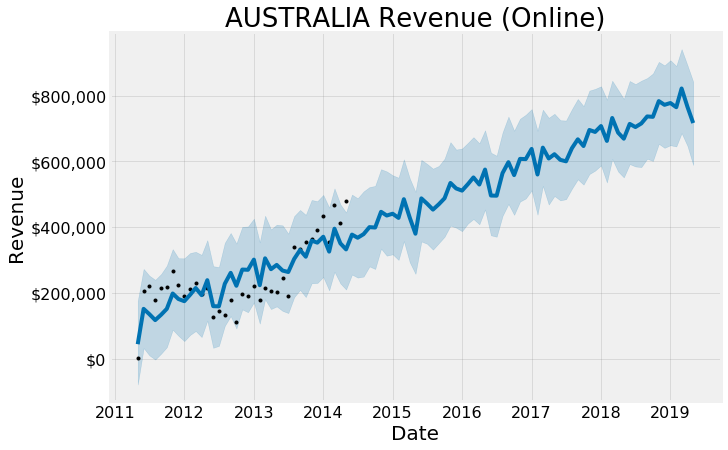

In [73]:
plt.figure(figsize=(18, 6))
AU_model.plot(AU_forecast, xlabel = 'Date', ylabel = 'Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('AUSTRALIA Revenue (Online)');

# Trend and Forecast Visualization

In [74]:
AU_names = ['AU_%s' % column for column in AU_forecast.columns]

merge_AU_forecast = AU_forecast.copy()

merge_AU_forecast.columns = AU_names

forecast = merge_AU_forecast
forecast = forecast.rename(columns={'AU_ds': 'Date'})
forecast.head()

,Date,AU_trend,AU_yhat_lower,AU_yhat_upper,AU_trend_lower,AU_trend_upper,AU_additive_terms,AU_additive_terms_lower,AU_additive_terms_upper,AU_yearly,AU_yearly_lower,AU_yearly_upper,AU_multiplicative_terms,AU_multiplicative_terms_lower,AU_multiplicative_terms_upper,AU_yhat
0,2011-05-01,125134.782897,-78679.746134,175499.657938,125134.782897,125134.782897,-81111.388799,-81111.388799,-81111.388799,-81111.388799,-81111.388799,-81111.388799,0.0,0.0,0.0,44023.394098
1,2011-06-01,132242.369012,32401.640353,272983.453265,132242.369012,132242.369012,19288.279995,19288.279995,19288.279995,19288.279995,19288.279995,19288.279995,0.0,0.0,0.0,151530.649007
2,2011-07-01,139120.678160,10152.979187,252530.143688,139120.678160,139120.678160,-3591.161075,-3591.161075,-3591.161075,-3591.161075,-3591.161075,-3591.161075,0.0,0.0,0.0,135529.517085
3,2011-08-01,146228.264273,-2661.742003,239814.932071,146228.264273,146228.264273,-28908.932501,-28908.932501,-28908.932501,-28908.932501,-28908.932501,-28908.932501,0.0,0.0,0.0,117319.331772
4,2011-09-01,153335.850382,15223.880893,257484.673415,153335.850382,153335.850382,-19715.668118,-19715.668118,-19715.668118,-19715.668118,-19715.668118,-19715.668118,0.0,0.0,0.0,133620.182264


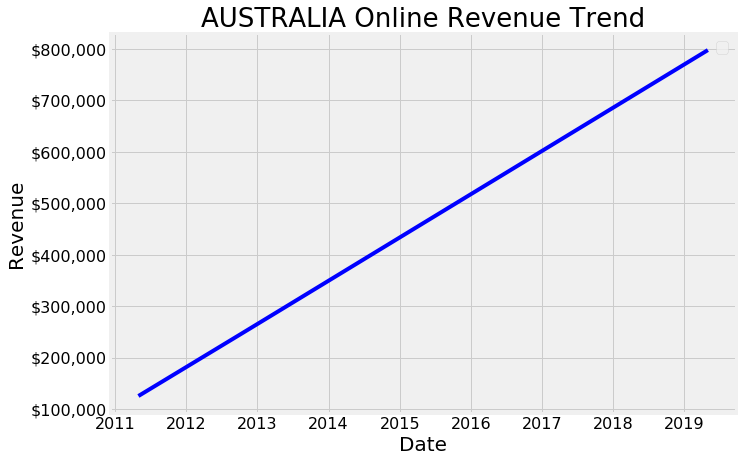

In [75]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['AU_trend'], 'b-')
#plt.plot(forecast['Date'], forecast['SW_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}

plt.title('AUSTRALIA Online Revenue Trend');

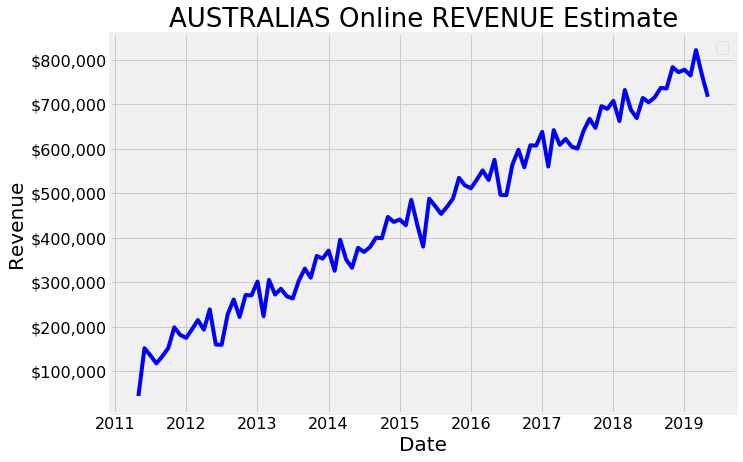

In [76]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['AU_yhat'], 'b-')
#plt.plot(forecast['Date'], forecast['SW_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}

plt.title('AUSTRALIAS Online REVENUE Estimate');

# Trends and Patterns
Now, we can use the Prophet Models to inspect different trends of these two Teritory in the data.

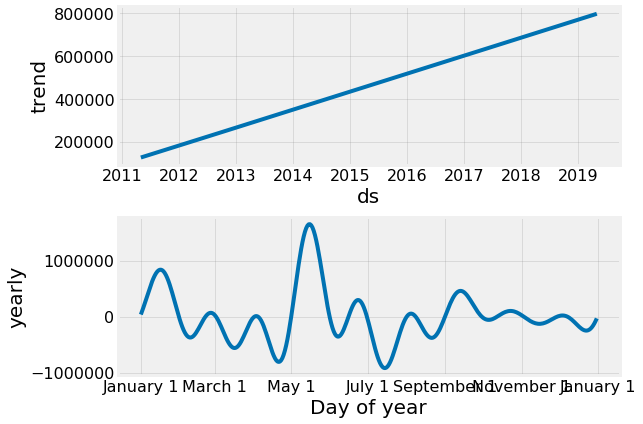

In [77]:
AU_model.plot_components(AU_forecast);

### Good to see that the revenue for  Australia Online have been linearly increasing over time and will be keep growing.